In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Subset

In [31]:
# Параметры
latent_dim = 32
input_shape = 784  # 28x28
batch_size = 128
epochs = 50
device = torch.device("cpu")
test_string = 'VYL9'

# Количество классов для цифр и букв
num_digit_classes = 10  # 0-9
num_letter_classes = 26  # A-Z, a-z 52

In [15]:
# ======================
# Conditional VAE для цифр
# ======================

class ConditionalEncoderDigits(nn.Module):
    def __init__(self):
        super(ConditionalEncoderDigits, self).__init__()
        self.fc1 = nn.Linear(input_shape + num_digit_classes, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)
        
    def forward(self, x, y):
        y_onehot = F.one_hot(y, num_classes=num_digit_classes).float()
        x_cond = torch.cat([x, y_onehot], dim=1)
        x_cond = torch.relu(self.fc1(x_cond))
        x_cond = torch.relu(self.fc2(x_cond))
        mu = self.fc_mu(x_cond)
        log_var = self.fc_logvar(x_cond)
        return mu, log_var

class ConditionalDecoderDigits(nn.Module):
    def __init__(self):
        super(ConditionalDecoderDigits, self).__init__()
        self.fc1 = nn.Linear(latent_dim + num_digit_classes, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, input_shape)
        
    def forward(self, z, y):
        y_onehot = F.one_hot(y, num_classes=num_digit_classes).float()
        z_cond = torch.cat([z, y_onehot], dim=1)
        z_cond = torch.relu(self.fc1(z_cond))
        z_cond = torch.relu(self.fc2(z_cond))
        reconstruction = torch.sigmoid(self.fc3(z_cond))
        return reconstruction

class ConditionalVAE_Digits(nn.Module):
    def __init__(self):
        super(ConditionalVAE_Digits, self).__init__()
        self.encoder = ConditionalEncoderDigits()
        self.decoder = ConditionalDecoderDigits()
        
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
        
    def forward(self, x, y):
        mu, log_var = self.encoder(x, y)
        z = self.reparameterize(mu, log_var)
        reconstruction = self.decoder(z, y)
        return reconstruction, mu, log_var
    
    def generate(self, y, num_samples=1):
        with torch.no_grad():
            z = torch.randn(num_samples, latent_dim).to(device)
            y = torch.tensor([y] * num_samples).to(device)
            return self.decoder(z, y)

In [14]:
# ======================
# Conditional VAE для букв
# ======================

class ConditionalEncoderLetters(nn.Module):
    def __init__(self):
        super(ConditionalEncoderLetters, self).__init__()
        self.fc1 = nn.Linear(input_shape + num_letter_classes, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)
        
    def forward(self, x, y):
        y_onehot = F.one_hot(y, num_classes=num_letter_classes).float()
        x_cond = torch.cat([x, y_onehot], dim=1)
        x_cond = torch.relu(self.fc1(x_cond))
        x_cond = torch.relu(self.fc2(x_cond))
        x_cond = torch.relu(self.fc3(x_cond))
        mu = self.fc_mu(x_cond)
        log_var = self.fc_logvar(x_cond)
        return mu, log_var

class ConditionalDecoderLetters(nn.Module):
    def __init__(self):
        super(ConditionalDecoderLetters, self).__init__()
        self.fc1 = nn.Linear(latent_dim + num_letter_classes, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, input_shape)
        
    def forward(self, z, y):
        y_onehot = F.one_hot(y, num_classes=num_letter_classes).float()
        z_cond = torch.cat([z, y_onehot], dim=1)
        z_cond = torch.relu(self.fc1(z_cond))
        z_cond = torch.relu(self.fc2(z_cond))
        z_cond = torch.relu(self.fc3(z_cond))
        reconstruction = torch.sigmoid(self.fc4(z_cond))
        return reconstruction

class ConditionalVAE_Letters(nn.Module):
    def __init__(self):
        super(ConditionalVAE_Letters, self).__init__()
        self.encoder = ConditionalEncoderLetters()
        self.decoder = ConditionalDecoderLetters()
        
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
        
    def forward(self, x, y):
        mu, log_var = self.encoder(x, y)
        z = self.reparameterize(mu, log_var)
        reconstruction = self.decoder(z, y)
        return reconstruction, mu, log_var
    
    def generate(self, y, num_samples=1):
        with torch.no_grad():
            z = torch.randn(num_samples, latent_dim).to(device)
            y = torch.tensor([y] * num_samples).to(device)
            return self.decoder(z, y)

In [16]:
# ======================
# Функция потерь
# ======================

def loss_function(recon_x, x, mu, log_var):
    BCE = nn.functional.binary_cross_entropy(
        recon_x, x.view(-1, input_shape), reduction='sum'
    )
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

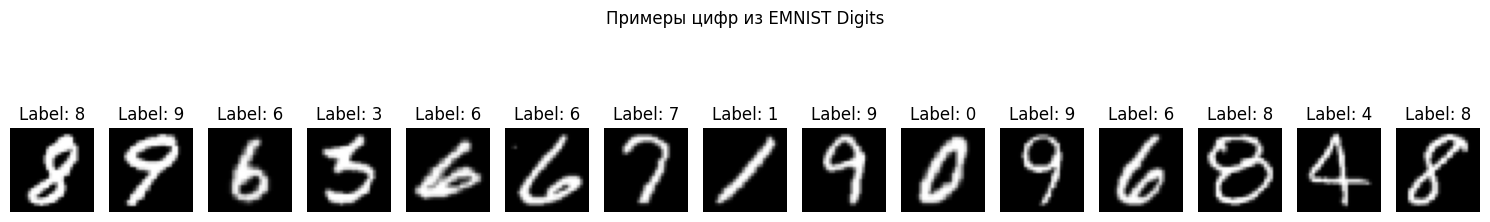

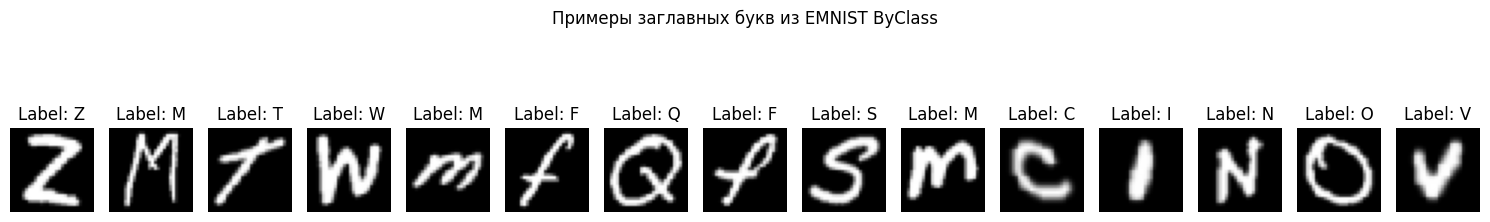

In [20]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.permute(1, 0, 2)),  # Поворот на 90 градусов против часовой
    transforms.Lambda(lambda x: torch.flip(x, [1])),  # Зеркальное отражение по вертикали
    transforms.Lambda(lambda x: torch.clamp(x, 0, 1))
])

# Загрузка EMNIST Digits (только цифры)
digits_dataset = torchvision.datasets.EMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform,
    split='digits'  # Только цифры 0-9
)

# Загрузка EMNIST ByClass (буквы и цифры, раздельные классы)
full_byclass_dataset = torchvision.datasets.EMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform,
    split='byclass'  # Включает A-Z, a-z и 0-9
)

# Получаем список классов, например: ['0', '1', ..., 'A', ..., 'Z', ..., 'a', ..., 'z']
classes = full_byclass_dataset.classes

# Определяем индексы заглавных букв в списке классов
capital_label_indices = [i for i, c in enumerate(classes) if c.isupper() and c.isalpha()]

# Фильтрация только заглавных букв
capital_indices = [i for i, (_, label) in enumerate(full_byclass_dataset) if label in capital_label_indices]
letters_dataset = torch.utils.data.Subset(full_byclass_dataset, capital_indices)

# ======================
# Функция отображения
# ======================

def show_samples(dataset, title, n_samples=15, is_letters=False, class_list=None):
    plt.figure(figsize=(15, 3))
    plt.suptitle(title)

    for i in range(n_samples):
        if isinstance(dataset, torch.utils.data.Subset):
            img, label = dataset.dataset[dataset.indices[i]]
        else:
            img, label = dataset[i]

        if is_letters and class_list:
            label_char = class_list[label]
        else:
            label_char = str(label)

        plt.subplot(1, n_samples, i+1)
        plt.imshow(img.permute(1, 2, 0).squeeze(), cmap='gray')
        plt.title(f'Label: {label_char}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# ======================
# Отображение примеров
# ======================

# Показываем примеры цифр
show_samples(digits_dataset, "Примеры цифр из EMNIST Digits")

# Показываем примеры заглавных букв
show_samples(letters_dataset, "Примеры заглавных букв из EMNIST ByClass", is_letters=True, class_list=classes)

# ======================
# DataLoaders
# ======================

digit_loader = DataLoader(digits_dataset, batch_size=batch_size, shuffle=True)
letter_loader = DataLoader(letters_dataset, batch_size=batch_size, shuffle=True)

In [27]:
model_digits = ConditionalVAE_Digits().to(device)
optimizer1 = optim.Adam(model_digits.parameters(), lr=3e-3)

In [28]:
model_digits.train()
for epoch in range(epochs):
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(digit_loader):
        data = data.to(device)
        labels = labels.to(device)
        optimizer1.zero_grad()
        
        recon_batch, mu, log_var = model_digits(data.view(-1, input_shape), labels)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer1.step()
        
    print(f'Digits Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(digit_loader.dataset):.4f}')

Digits Epoch 1/10, Loss: 170.0277
Digits Epoch 2/10, Loss: 149.1989
Digits Epoch 3/10, Loss: 145.2106
Digits Epoch 4/10, Loss: 143.5578
Digits Epoch 5/10, Loss: 142.7494
Digits Epoch 6/10, Loss: 142.1303
Digits Epoch 7/10, Loss: 141.7113
Digits Epoch 8/10, Loss: 141.4060
Digits Epoch 9/10, Loss: 141.1195
Digits Epoch 10/10, Loss: 140.9110


In [24]:
model_letters = ConditionalVAE_Letters().to(device)
optimizer2 = optim.Adam(model_letters.parameters(), lr=3e-3)

In [25]:
model_letters.train()
for epoch in range(epochs):
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(letter_loader):
        data = data.to(device)
        labels = labels.to(device) - 10  
        optimizer2.zero_grad()
        
        recon_batch, mu, log_var = model_letters(data.view(-1, input_shape), labels)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer2.step()
        
    print(f'Letters Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(letter_loader.dataset):.4f}')

Letters Epoch 1/50, Loss: 202.7469
Letters Epoch 2/50, Loss: 175.5069
Letters Epoch 3/50, Loss: 172.2419
Letters Epoch 4/50, Loss: 170.7517
Letters Epoch 5/50, Loss: 169.8476
Letters Epoch 6/50, Loss: 169.1723
Letters Epoch 7/50, Loss: 168.6697
Letters Epoch 8/50, Loss: 168.2192
Letters Epoch 9/50, Loss: 167.9372
Letters Epoch 10/50, Loss: 167.5209
Letters Epoch 11/50, Loss: 167.4110
Letters Epoch 12/50, Loss: 167.0895
Letters Epoch 13/50, Loss: 166.8703
Letters Epoch 14/50, Loss: 166.7025
Letters Epoch 15/50, Loss: 166.5634
Letters Epoch 16/50, Loss: 166.3351
Letters Epoch 17/50, Loss: 166.2170
Letters Epoch 18/50, Loss: 166.0554
Letters Epoch 19/50, Loss: 165.9648
Letters Epoch 20/50, Loss: 165.8058
Letters Epoch 21/50, Loss: 165.6692
Letters Epoch 22/50, Loss: 165.5737
Letters Epoch 23/50, Loss: 165.4819
Letters Epoch 24/50, Loss: 165.3507
Letters Epoch 25/50, Loss: 165.2557
Letters Epoch 26/50, Loss: 165.2219
Letters Epoch 27/50, Loss: 165.1402
Letters Epoch 28/50, Loss: 165.0833
L

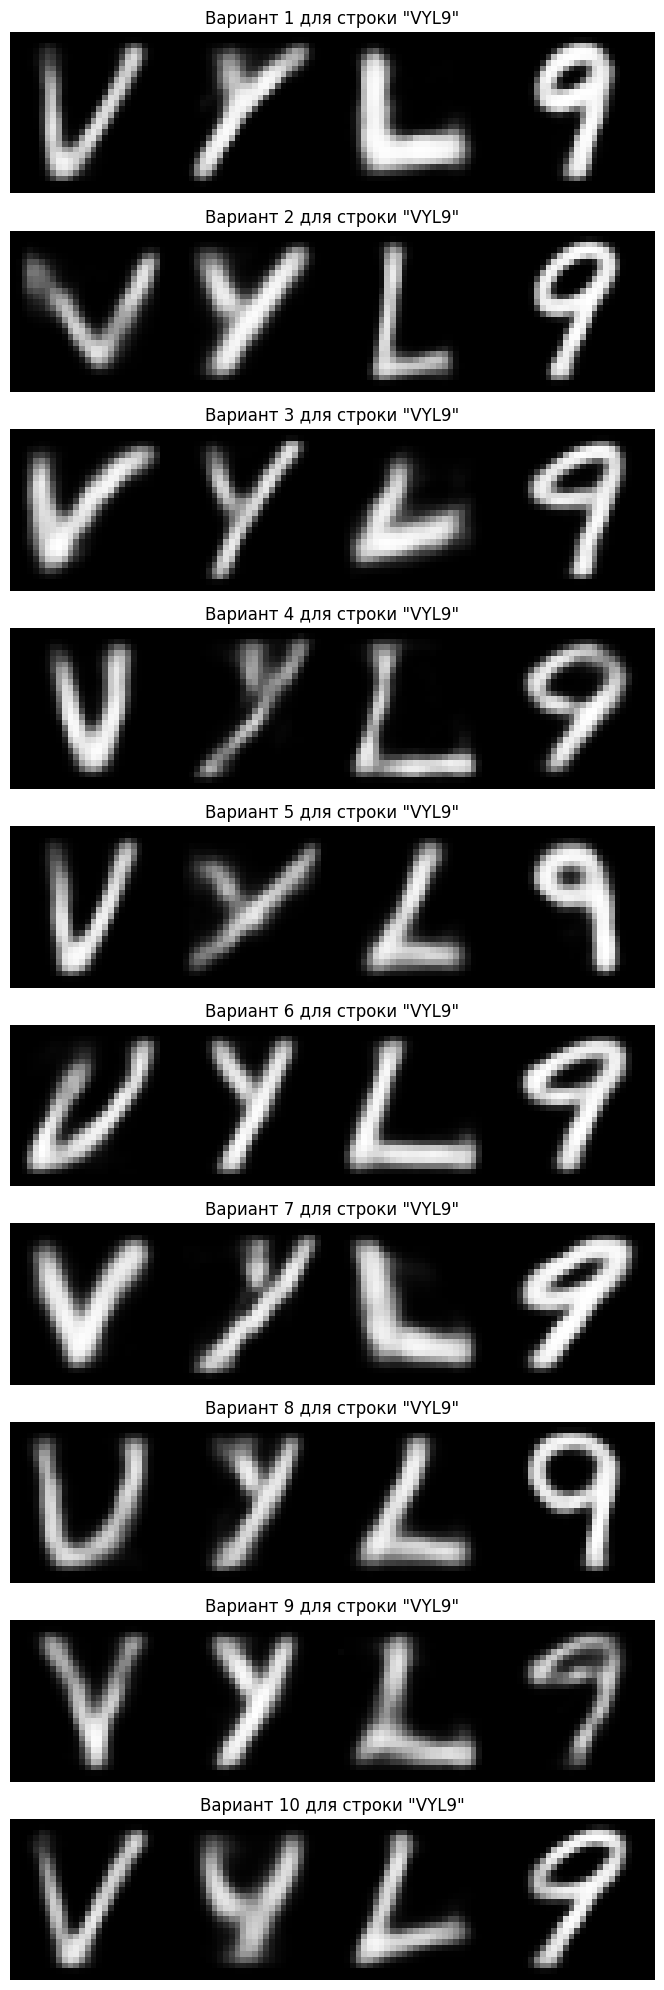

In [30]:
# ======================
# Генерация символов по заданной строке
# ======================

def generate_string_conditional(test_string, num_generations=10):
    model_digits.eval()
    model_letters.eval()
    
    generated_strings = []
    
    with torch.no_grad():
        for _ in range(num_generations):
            generated_parts = []
            
            for char in test_string:
                if char.isdigit():
                    # Генерация цифры
                    label = int(char)
                    generated = model_digits.generate(torch.tensor(label).to(device)).view(1, 1, 28, 28)
                else:
                    # Генерация буквы
                    char_upper = char.upper()
                    if char == char_upper:
                        label = ord(char) - ord('A')
                    else:
                        label = ord(char) - ord('a') + 26
                    generated = model_letters.generate(torch.tensor(label).to(device)).view(1, 1, 28, 28)
                
                # Поворот изображения на 90 градусов против часовой стрелки и зеркальное отражение по вертикали
                generated = torch.rot90(generated, k=-3, dims=[2, 3])  # Поворот против часовой
                generated = torch.flip(generated, [2])  # Зеркальное отражение по вертикали
                
                generated_parts.append(generated)
            
            generated_string = torch.cat(generated_parts, dim=3)
            generated_strings.append(generated_string.cpu())
    
    return generated_strings

# Визуализация результатов
def visualize_generated_strings(generated_strings, test_string):
    """Визуализирует сгенерированные строки"""
    plt.figure(figsize=(15, 2 * len(generated_strings)))
    
    for i, string_img in enumerate(generated_strings):
        plt.subplot(len(generated_strings), 1, i+1)
        plt.imshow(string_img.squeeze(), cmap='gray')
        plt.title(f'Вариант {i+1} для строки "{test_string}"')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Пример использования
generated_strings = generate_string_conditional(test_string, num_generations=10)
visualize_generated_strings(generated_strings, test_string)